In [3]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from collections import Counter
from sklearn.manifold import TSNE

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

import warnings
warnings.filterwarnings("ignore")

# Jeu de donnée NIPS

NIPS est un jeu de données représentant les publications aux conférences NIPS de 1987 à 2003. Il est constitué des structures suivantes : 
- words  : tableau contenant l’ensemble des mots. 
- authors_names : tableau contenant les noms des auteurs. 
- counts  : matrice où chaque élément i,j correspond au nombre de fois où le mot i est présent dans le document j. 
- docs_authors : matrice où chaque élément i,j vaut 1 si j est l’un des auteurs du document i sinon 0. 
- aw_counts : matrice où chaque élément i, j correspond au nombre de fois où le mot i a été utilisé dans les documents dont j est l’un des auteurs. 
 
Ce rapport se compose essentiellement de 3 sous parties :
- Pré-traitement. 
- Visualisation. 
- Analyse sémantique latente. 

## Chargement des données

In [2]:
mat = scipy.io.loadmat('nips_1-17.mat')
#mat

In [3]:
mat["words"].shape, mat["docs_names"].shape, mat["authors_names"].shape

((1, 14036), (1, 2484), (1, 2865))

In [4]:
mat["docs_authors"].shape, mat['aw_counts'].shape, mat['counts'].shape

((2484, 2865), (14036, 2865), (14036, 2484))

# 1. Pré-traitement

En règle général, les données textuelles présentent toujours certaines caractéristiques qui peuvent entraver les opérations d’analyse, des pré-traitements sont donc nécessaires. Dans notre cas, nous incluons :
- L’élimination éventuelle de certains mots dit vide et non discriminant.
- La lemmatisation naïve, qui consiste à remplacer chaque mot par sa forme canonique.


 1- Elimination des stops words: 
 
Au début, nous avions voulu supprimer les Stop Words de nos documents. Car un mot est évalué à sa distribution dans le document et un mot dont la distribution est uniforme est dit “vide”. Cependant, après analyse, nous constatons que nos documents ne contiennent que 40 Stop Words sur 318 (vu que les données sont en Anglais). Nous avons donc jugé inutile de les supprimer. 


In [7]:
# all_words (list) : contenant tous les mots de notre corpus  
all_words = list(map(lambda x: x[0], mat["words"][0]))  
#all_words

In [490]:
len(ENGLISH_STOP_WORDS)

318

In [8]:
#version 1
occ=0
for i in all_words:
    if i in list(ENGLISH_STOP_WORDS):
        occ+=1
print(occ) #40 stop words
#version 2
len(list(filter(lambda x: x in ENGLISH_STOP_WORDS, all_words)))

40


40

2- La lemmatisation naïve: 

La lemmatisation est un processus qui remplace les mots d’une même famille (différentes variantes pour un mot) par leur forme canonique (un unique mot). On propose une lemmatisation naïve, qui consiste à remplacer les mots au pluriel, les mots se terminant avec “Ed” et “ING” par leur lemme si il existe sinon on garde le mot d’origine. Suite à ces deux étapes, 2688 mots sont modifiés soient 20% de nos mots.


In [10]:
data = np.array(mat["counts"].todense()) #shape (14036, 2484)

In [11]:
cmpt = 0
for i, w in enumerate(all_words):
    if w[-1] =="s" and w[:-1] in all_words:
        indice = all_words.index(w)
        #all_words[i] = w[:-1]
        data[indice] += data[i]
        data[i] = 0 
        cmpt += 1
    elif w[-2:] == "ed" and w[:-1] in all_words:
        indice = all_words.index(w)
        data[indice] += data[i]
        data[i] = 0 
        cmpt += 1
    elif w[-3:] == "ing" and w[:-3] in all_words:
        indice = all_words.index(w)
        data[indice] += data[i]
        data[i] = 0 
        cmpt += 1
cmpt

2638

In [12]:
cmpt/len(all_words) #20% de du corpus

0.1879452835565688

## 2.Analyse sémantique latente:

Il serait intéressant de représenter l’ensemble des documents par une matrice document-thèmes dans laquelle chacune des lignes correspond à un document et chacune des colonnes correspond à un topic. Pour se faire on utilisera une LDA (allocation de Dirichlet latente). Cette technique qui identifie de manière non-supervisée des thèmes à partir de notre corpus textuel.

Nous décidons d’en extraire que 5 thèmes pour une meilleure visualisation à l’aide de TSNE:


# Visualisation avec 5 topics

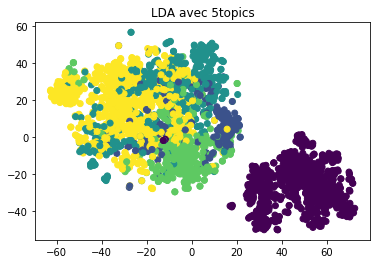

In [190]:
nb_topic = 5
lda = LatentDirichletAllocation(nb_topic)
emb_lda = lda.fit_transform(data.T)

plt.title("LDA avec "+str(nb_topic)+ " topics")
doc_ebd = TruncatedSVD(n_components=100).fit_transform(mat["counts"].T) 
tsne = TSNE(2).fit_transform(doc_ebd) 
plt.scatter(*tsne.T, c=emb_lda.argmax(1))
plt.show()

Intuitivement, nous aurions envie de dire que:

- Le thème ‘violet’ se démarque assez bien des autres thèmes et qu’il est commun à plusieurs documents. 

- Le thème ‘bleu’ représente une minorité de document.

- Les thèmes en ‘jaune’ et ‘bleu turquoise’ ne sont pas très bien séparés, nous aurions tendance à croire qu’ils partagent des mots un vocabulaire. 


L’étape qui suit, consiste à regarder les mots que chaque topic. Pour des raisons de compréhension nous visualisons les 20 mots les plus fréquents. Nous obtenons :

In [238]:
emb_lda.shape
lda.components_.shape
imp_words = lda.components_.argsort()[:,-15:] #les mots les plus importants
main_words_topic = []
for i, w in enumerate(imp_words):
    #print('topice',i)
    main_words_topic.append([all_words[j] for j in imp_words[i]])

In [239]:
print(main_words_topic)

[['computation', 'computer', 'science', 'school', 'william', 'van', 'steveninck', 'bialek', 'rob', 'tishby', 'naftali', 'brenner', 'code', 'neural', 'universality'], ['case', 'network', 'space', 'linear', 'distribution', 'problem', 'probability', 'neural', 'number', 'model', 'error', 'set', 'function', 'algorithm', 'data'], ['signal', 'circuit', 'analog', 'system', 'noise', 'synaptic', 'model', 'figure', 'output', 'function', 'neuron', 'time', 'neural', 'network', 'input'], ['cell', 'view', 'spatial', 'direction', 'field', 'system', 'information', 'response', 'stimulus', 'motion', 'hand', 'figure', 'image', 'visual', 'model'], ['hidden', 'layer', 'control', 'model', 'performance', 'recognition', 'set', 'output', 'figure', 'system', 'state', 'input', 'neural', 'time', 'network']]


Néanmoins, on observe que certains mots tel que ‘neural’ possède une fréquence semblable dans chacun des topics. De tels mots sont dit ‘inutile’ ou ‘non discriminant’ car ils ne nous permette pas de distinguer nos topics les uns par rapport aux autres. Par conséquent, on les supprime : 


In [240]:
#version 1
for i, lw in enumerate(main_words_topic):
    for j in lw:
        for t in main_words_topic[i+1:]:
            b=0
            if j in t:
                b=1
                main_words_topic[i].remove(j)
            if b :
                break
#version 2 #tmp = tuple(map(lambda x: tuple(x), main_words_topic))
                
main_words_topic      

[['computation',
  'computer',
  'science',
  'school',
  'william',
  'van',
  'steveninck',
  'bialek',
  'rob',
  'tishby',
  'naftali',
  'brenner',
  'code',
  'universality'],
 ['case',
  'space',
  'linear',
  'distribution',
  'problem',
  'probability',
  'number',
  'error',
  'function',
  'algorithm',
  'data'],
 ['signal',
  'circuit',
  'analog',
  'noise',
  'synaptic',
  'figure',
  'function',
  'neuron',
  'neural',
  'input'],
 ['cell',
  'view',
  'spatial',
  'direction',
  'field',
  'information',
  'response',
  'stimulus',
  'motion',
  'hand',
  'image',
  'visual'],
 ['hidden',
  'layer',
  'control',
  'model',
  'performance',
  'recognition',
  'set',
  'output',
  'figure',
  'system',
  'state',
  'input',
  'neural',
  'time',
  'network']]

- TOPIC1 : Les documents de ce topic semblent parler de LEBREUX
- TOPIC2 : Les documents associés semblent abordés le génie informatique d’un point de vue matériels
- TOPIC3 : Les documents de ce topic semblent aborder une partie en Machine Learning “Réseau de neurone”
- TOPIC4 : Les documents de ce topic semblent aborder des thématiques en rapport avec la neuro biologie et plus particulièrement du cortex visuel du cerveau humain 
- TOPIC5 : Les documents de ce topic abordent  le Machine Learning d’un point de vue général.


In [45]:
lda2 = LatentDirichletAllocation(5)
emb_lda2 = lda2.fit_transform(data2)

In [46]:
data2.shape

(2484, 2865)

In [241]:
doc_date = list(map(lambda x: int(x[0].split('/')[0]), mat['docs_names'][0]))

In [242]:
len(doc_date)

2484

# Evolution des documents dans le temps de chaque topics.


Maintenant que nous disposons des sacs de mots de chaque topic, l’étape suivante consiste à voir l'évolution des thèmes selon les années.

In [245]:
topics = emb_lda.argmax(1)

In [260]:
np.unique(topics)

array([0, 1, 2, 3, 4], dtype=int64)

In [247]:
date_topic = [ (d,t) for d, t in zip(doc_date,topics) ]
date_topic

[(1987, 1),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 1),
 (1987, 3),
 (1987, 1),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 4),
 (1987, 2),
 (1987, 4),
 (1987, 2),
 (1987, 2),
 (1987, 1),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 1),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 4),
 (1987, 4),
 (1987, 2),
 (1987, 2),
 (1987, 4),
 (1987, 2),
 (1987, 4),
 (1987, 1),
 (1987, 2),
 (1987, 2),
 (1987, 1),
 (1987, 4),
 (1987, 3),
 (1987, 2),
 (1987, 4),
 (1987, 2),
 (1987, 3),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 1),
 (1987, 3),
 (1987, 3),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 4),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 4),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 1),
 (1987, 3),
 (1987, 4),
 (1987, 4),
 (1987, 4),
 (1987, 3),
 (1987, 2),
 (1987, 2),
 (1987, 4),
 (1987, 3),
 (1987, 2),
 (1987, 2),
 (1987, 4),
 (1987, 2),
 (1987, 4),
 (1987, 4),
 (1987, 4),
 (1987, 2),
 (1987, 4),
 (1987, 4),
 (19

In [248]:
date_topic_nb = Counter(date_topic)
date_topic_nb

Counter({(1987, 1): 10,
         (1987, 2): 49,
         (1987, 3): 9,
         (1987, 4): 22,
         (1988, 4): 37,
         (1988, 1): 13,
         (1988, 2): 33,
         (1988, 3): 12,
         (1989, 3): 12,
         (1989, 2): 28,
         (1989, 4): 41,
         (1989, 1): 20,
         (1990, 3): 15,
         (1990, 2): 32,
         (1990, 1): 38,
         (1990, 4): 58,
         (1991, 4): 51,
         (1991, 2): 24,
         (1991, 3): 21,
         (1991, 1): 48,
         (1992, 1): 39,
         (1992, 2): 24,
         (1992, 4): 44,
         (1992, 3): 20,
         (1993, 1): 59,
         (1993, 4): 45,
         (1993, 2): 26,
         (1993, 3): 14,
         (1994, 3): 18,
         (1994, 4): 37,
         (1994, 2): 23,
         (1994, 1): 62,
         (1995, 1): 71,
         (1995, 3): 22,
         (1995, 4): 38,
         (1995, 2): 21,
         (1996, 1): 88,
         (1996, 4): 23,
         (1996, 3): 23,
         (1996, 2): 18,
         (1997, 3): 20,
         (1997, 4

In [249]:
date_topic_sorted = sorted(date_topic, key=lambda kv: kv[1])
date_topic_sorted

[(2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (2000, 0),
 (20

In [250]:
date_topic_nb = Counter(date_topic_sorted)
date_topic_nb

Counter({(2000, 0): 151,
         (2001, 0): 192,
         (2002, 0): 204,
         (2003, 0): 197,
         (1987, 1): 10,
         (1988, 1): 13,
         (1989, 1): 20,
         (1990, 1): 38,
         (1991, 1): 48,
         (1992, 1): 39,
         (1993, 1): 59,
         (1994, 1): 62,
         (1995, 1): 71,
         (1996, 1): 88,
         (1997, 1): 82,
         (1998, 1): 89,
         (1999, 1): 98,
         (1987, 2): 49,
         (1988, 2): 33,
         (1989, 2): 28,
         (1990, 2): 32,
         (1991, 2): 24,
         (1992, 2): 24,
         (1993, 2): 26,
         (1994, 2): 23,
         (1995, 2): 21,
         (1996, 2): 18,
         (1997, 2): 18,
         (1998, 2): 21,
         (1999, 2): 21,
         (1987, 3): 9,
         (1988, 3): 12,
         (1989, 3): 12,
         (1990, 3): 15,
         (1991, 3): 21,
         (1992, 3): 20,
         (1993, 3): 14,
         (1994, 3): 18,
         (1995, 3): 22,
         (1996, 3): 23,
         (1997, 3): 20,
         (199

In [251]:
date_occ = np.array(list(map(lambda x: [x[0][0], x[0][1], x[1]], list(date_topic_nb.items()))))
date_occ

array([[2000,    0,  151],
       [2001,    0,  192],
       [2002,    0,  204],
       [2003,    0,  197],
       [1987,    1,   10],
       [1988,    1,   13],
       [1989,    1,   20],
       [1990,    1,   38],
       [1991,    1,   48],
       [1992,    1,   39],
       [1993,    1,   59],
       [1994,    1,   62],
       [1995,    1,   71],
       [1996,    1,   88],
       [1997,    1,   82],
       [1998,    1,   89],
       [1999,    1,   98],
       [1987,    2,   49],
       [1988,    2,   33],
       [1989,    2,   28],
       [1990,    2,   32],
       [1991,    2,   24],
       [1992,    2,   24],
       [1993,    2,   26],
       [1994,    2,   23],
       [1995,    2,   21],
       [1996,    2,   18],
       [1997,    2,   18],
       [1998,    2,   21],
       [1999,    2,   21],
       [1987,    3,    9],
       [1988,    3,   12],
       [1989,    3,   12],
       [1990,    3,   15],
       [1991,    3,   21],
       [1992,    3,   20],
       [1993,    3,   14],
 

In [252]:
date_topic

[(1987, 1),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 1),
 (1987, 3),
 (1987, 1),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 4),
 (1987, 2),
 (1987, 4),
 (1987, 2),
 (1987, 2),
 (1987, 1),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 1),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 4),
 (1987, 4),
 (1987, 2),
 (1987, 2),
 (1987, 4),
 (1987, 2),
 (1987, 4),
 (1987, 1),
 (1987, 2),
 (1987, 2),
 (1987, 1),
 (1987, 4),
 (1987, 3),
 (1987, 2),
 (1987, 4),
 (1987, 2),
 (1987, 3),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 1),
 (1987, 3),
 (1987, 3),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 4),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 4),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 2),
 (1987, 1),
 (1987, 3),
 (1987, 4),
 (1987, 4),
 (1987, 4),
 (1987, 3),
 (1987, 2),
 (1987, 2),
 (1987, 4),
 (1987, 3),
 (1987, 2),
 (1987, 2),
 (1987, 4),
 (1987, 2),
 (1987, 4),
 (1987, 4),
 (1987, 4),
 (1987, 2),
 (1987, 4),
 (1987, 4),
 (19

In [253]:
np.unique(date_occ[:, 1])

array([0, 1, 2, 3, 4], dtype=int64)

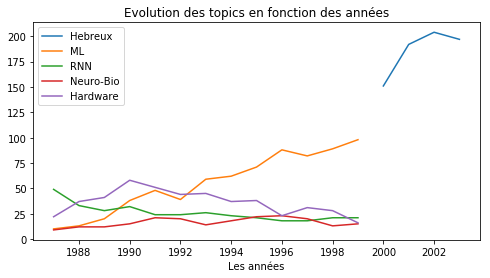

In [255]:
#visualisation 1 : avec label = theme
# !le schema varie à chaque execution de LDA
liste = ["Hebreux","ML" , "RNN", "Neuro-Bio","Hardware" ]
plt.figure(figsize=(8, 4))
for p  in np.unique(date_occ[:, 1]):
    
    plt.plot(*date_occ[np.where(date_occ[:, 1] == p), ::2][0].T, label=liste[p])
plt.title("Evolution des topics en fonction des années")
plt.xlabel("Les années")
plt.legend()
plt.show()


5


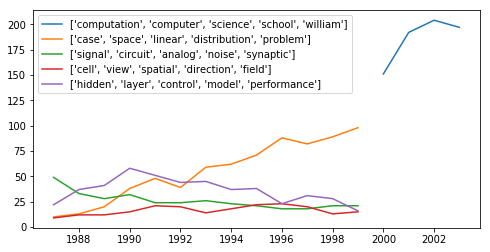

In [256]:
#visualisation 2 : avec label = les mots les plus fréquents
plt.figure(figsize=(8, 4))
print(len(main_words_topic   ))
for p in np.unique(date_occ[:, 1]):
    plt.plot(*date_occ[np.where(date_occ[:, 1] == p), ::2][0].T, label=main_words_topic[p][:5])
plt.legend()
plt.show() 

Les documents publiés en rapport avec le Machine Learning semblent prendre de l’importance au file des années. 

## Auteurs en fonction du thème et de leurs publication

Il est intéressant de visualiser les auteurs selon les thèmes et le nombres leurs publications.

In [257]:
auteurs = list(map(lambda x: x[0], mat['authors_names'][0]))
len(auteurs)

2865

In [107]:
len(topics)

2484

In [108]:
topics

array([4, 1, 1, ..., 0, 0, 0], dtype=int64)

In [112]:
a_doc_pub[ 'Baxter_W']

(1, 3)

In [110]:
test = { "a": 1, "b": 2, "c": 3}
sum(list(map(lambda x: x, test.values())))
sum(test.values())

6

In [298]:
a_topic= {}
a_nb_pub = {}
for a, vect in zip(auteurs, mat["docs_authors"].todense().T):
    #print(vect[0a_d])
    a_topic[a] = np.where(vect != 0)[1]
   # sorted(Counter(topics[indice]).items(), key=lambda k: k[1])[-1][0] a_all_docs = []

for a, d in a_topic.items():
    a_topic[a] = sorted(Counter(topics[d]).items(), key = lambda k: k[1])[-1][0]
    a_nb_pub[a] = sum(Counter(topics[d]).values())

a_doc_pub = {}
for (a, pub), (a2, t)  in zip(a_nb_pub.items(), a_topic.items()):
    if t not in a_doc_pub.keys():
        #print(t)
        a_doc_pub[t] = []
    a_doc_pub[t].append([a,pub])
#a_doc_pub

In [297]:
# auteur_ nb pub _ topic => trier par topic, par pub
for t in a_doc_pub:
    print(" Auteurs qui ont le plus publié dans le topic "+str(t))
    print(list(reversed(sorted(a_doc_pub[t], key = lambda k: k[1])))[:15])

 Auteurs qui ont le plus publié dans le topic 4
[['Singh_S', 22], ['Mozer_M', 20], ['Thrun_S', 15], ['Barto_A', 15], ['Platt_J', 12], ['Lippmann_R', 12], ['LeCun_Y', 12], ['Waibel_A', 11], ['Giles_C', 11], ['Touretzky_D', 10], ['Kawato_M', 10], ['Cottrell_G', 10], ['Tesauro_G', 9], ['Sutton_R', 9], ['Morgan_N', 9]]
 Auteurs qui ont le plus publié dans le topic 0
[['Dayan_P', 29], ['Scholkopf_B', 21], ['Bialek_W', 20], ['Shawe-Taylor_J', 19], ['Jaakkola_T', 19], ['Tishby_N', 18], ['Singer_Y', 18], ['Obermayer_K', 16], ['Tenenbaum_J', 15], ['Opper_M', 15], ['Muller_K', 15], ['Weston_J', 13], ['Weiss_Y', 12], ['Rasmussen_C', 12], ['Horn_D', 12]]
 Auteurs qui ont le plus publié dans le topic 2
[['Ruppin_E', 14], ['Maass_W', 14], ['Bower_J', 11], ['Cauwenberghs_G', 10], ['Murray_A', 8], ['Jabri_M', 8], ['Cowan_J', 8], ['Meilijson_I', 7], ['Graf_H', 7], ['Coolen_A', 7], ['Zador_A', 6], ['Wang_D', 6], ['Principe_J', 6], ['Mead_C', 6], ['Lazzaro_J', 6]]
 Auteurs qui ont le plus publié dans le 

L'étape suivante consiste à visualiser les auteurs selon leur topic et leur fréquence de publication

# Visualisation des auteurs selon leur topic

In [303]:
data.T.shape # Doc par mot

(2484, 14036)

In [305]:
mat['aw_counts'].T.shape

(2865, 14036)

In [304]:
auteur_doc = {}
auteur_doc2 = []
for doc, a in zip(mat['docs_authors'].todense().T, auteurs):
    indice = np.where(doc != 0)[1]
    auteur_doc[a] = sorted(Counter(topics[indice]).items(), key=lambda k: k[1])[-1][0] 
    auteur_doc2.append(auteur_doc[a])

In [301]:
#auteur_doc
aut_embd = TruncatedSVD(n_components=100).fit_transform(mat['aw_counts'].T) 
tsne = TSNE(2).fit_transform(aut_embd) 

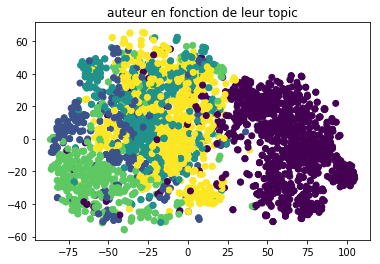

In [399]:
plt.title("auteur en fonction de leur topic")
plt.scatter(*tsne.T, c=[v for v in auteur_doc2])
plt.show()

# Visualisation des auteurs selon leur frequence de publication

In [306]:
publications = {}
publications = []
for doc, a in zip(mat['docs_authors'].todense().T, auteurs):
    indice = np.where(doc != 0)[1].sum()
    #auteur_doc[a] = sorted(Counter(topics[indice]).items(), key=lambda k: k[1])[-1][0] 
    #auteur_doc2.append(auteur_doc[a])

In [307]:
Counter(np.array(mat['docs_authors'].todense().sum(0))[0])

Counter({1: 1906,
         4: 95,
         2: 441,
         9: 13,
         3: 185,
         8: 28,
         6: 49,
         17: 1,
         11: 11,
         5: 49,
         7: 28,
         12: 12,
         15: 8,
         24: 1,
         20: 3,
         13: 4,
         10: 14,
         29: 1,
         19: 4,
         34: 1,
         46: 1,
         32: 1,
         14: 3,
         16: 1,
         21: 1,
         48: 1,
         18: 2,
         22: 1})

In [414]:
pub_freq = np.array(sorted(Counter(np.array(mat['docs_authors'].todense().sum(0))[0]).items()))

Text(0.5,1,'Nombre de publication par auteur')

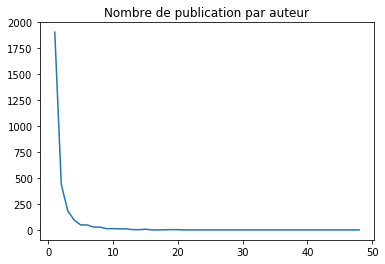

In [418]:
plt.plot(*pub_freq.T)
plt.title("Nombre de publication par auteur")

In [438]:
pub_freq

array([[   1, 1906],
       [   2,  441],
       [   3,  185],
       [   4,   95],
       [   5,   49],
       [   6,   49],
       [   7,   28],
       [   8,   28],
       [   9,   13],
       [  10,   14],
       [  11,   11],
       [  12,   12],
       [  13,    4],
       [  14,    3],
       [  15,    8],
       [  16,    1],
       [  17,    1],
       [  18,    2],
       [  19,    4],
       [  20,    3],
       [  21,    1],
       [  22,    1],
       [  24,    1],
       [  29,    1],
       [  32,    1],
       [  34,    1],
       [  46,    1],
       [  48,    1]], dtype=int64)

In [308]:
o = np.array(mat['docs_authors'].todense().sum(0))[0]
o

array([1, 1, 4, ..., 1, 2, 1], dtype=uint32)

In [454]:
groupe = (o == 1) * 1 + \
         (o > 1) * (o <= 4) * 2 + \
         (o > 4) * (o <= 8) * 3 + \
         (o > 8) * (o <= 12) * 4 

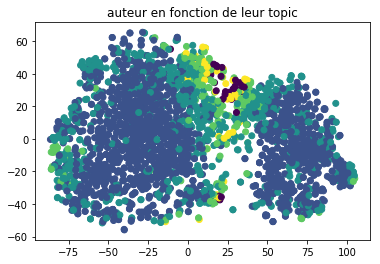

In [450]:
plt.title("auteur en fonction de leur topic")
plt.scatter(*tsne.T, c=[v for v in groupe])
plt.show()

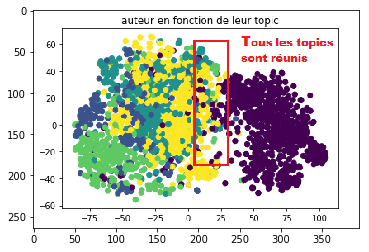

In [7]:
img=mpimg.imread('Images/Auteur en fonction de leur topic.png')
plt.imshow(img)

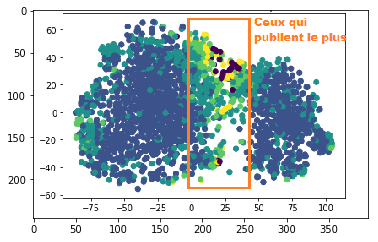

In [8]:
img=mpimg.imread('Images/auteur selon la publication.png')
plt.imshow(img)

Pour avoir une visualisation plus interprétable des auteurs en fonction du thème, nous avons associé à chaque auteur le thème dont il a le plus écrit. Concernant la visualisation des auteurs en fonction des publications, il nous a fallu discrétiser le nombre publications en 5 intervalles pour une meilleur visibilité. D'après les figures ci-dessus, nous aurions tendance à dire que les auteurs qui publient beaucoup, sont ceux qui écrivent dans au moins un thèmes. 

In [459]:
# reduc les docs, pr esperer rapprocher les mots similaires dans un espace latent
#tel mot est apparu dans tel et tel doc, context ==> un sens 
#plus la similarité cosinus implique une sémantique proche

(14036, 2484)

In [9]:
#Derniere étape : faire des clusters de mot

In [462]:
word_ebd = TruncatedSVD(n_components=100).fit_transform(mat["counts"]) 

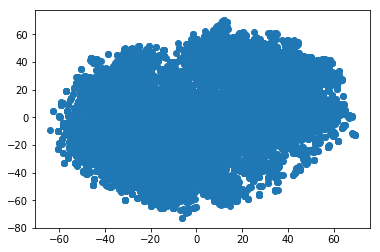

In [463]:
tsne_word = TSNE(2).fit_transform(word_ebd) 
plt.scatter(*tsne_word.T)
plt.show()

In [309]:
%matplotlib qt

In [ ]:
plt.title("Words embedding clustering")
plt.scatter(*tsne_word.T)
for label, x, y  in zip(all_words, *tsne_word.T):
    if np.random.randint(0, 1000) > 800:
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

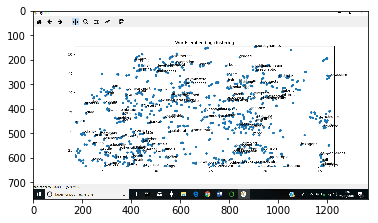

In [10]:
img=mpimg.imread('Images/1.png')
plt.imshow(img)

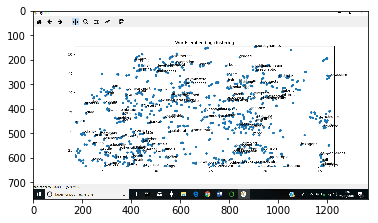

In [12]:
img=mpimg.imread('Images/2.png')
plt.imshow(img)

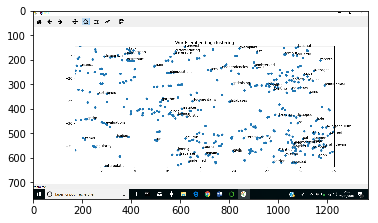

In [13]:
img=mpimg.imread('Images/3.png')
plt.imshow(img)

# Conclusion :

Dans ce rapport, nous avons utilisé plusieurs techniques d’exploration de données tels que : LDA pour extraire des thèmes de notre corpus dans le jeu de donnée NIPS, Truncated SVD, pour la réduction de dimensionnalité et PCA avec T-SNE pour la visualisation. Les représentations que nous avons obtenues grâce à ces techniques étaient pour la plupart compréhensibles et interprétables. Elles nous ont permis de tirer de nouvelles connaissances depuis nos jeux de données.